# Speech Emotion Recognition v0.2

In [1]:
import os

import librosa, librosa.display
import IPython.display as ipd
from random import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from scipy import signal
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## Preprocessing

### Fetching the audio data

In [2]:
# define constants
RAW_DATA_PATH = '../data/Audio_Speech_Actors_01-24/'
PROCESSED_DATA_PICKLE_PATH = '../data/df_normal.pkl'

In [3]:
dir_path = RAW_DATA_PATH
dir_list = os.listdir(dir_path)
dir_list.sort()
print(dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


### Declaring the labels

In [4]:
emotion_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
intensity_list = ['normal', 'strong']
statement_list = ['kids', 'dogs']
gender_list = ['female', 'male']

In [5]:
# Create a DataFrame for Data intel
columns = ['path', 'source', 'actor', 'gender', 'statement', 'repetition', 'intensity', 'emotion']
data_df = pd.DataFrame(columns=columns)

count = 0
for dir in dir_list:
  file_list = os.listdir(dir_path + dir)
  for file in file_list:
    nm = file.split('.')[0].split('-')

    file_path = dir_path + dir + '/' + file
    source = int(nm[1])
    emotion = int(nm[2]) - 1
    intensity = int(nm[3]) - 1
    statement = int(nm[4]) - 1
    repetition = int(nm[5])
    actor = int(nm[6])
    gender = actor%2

    data_df.loc[count] = [file_path, source, actor, gender, statement, repetition, intensity, emotion]
    count += 1

print(len(data_df))
data_df.head(3)

1440


,path,source,actor,gender,statement,repetition,intensity,emotion
0,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,0,1,0,0
1,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,0,2,0,0
2,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,1,1,0,0


## Plotting the audio file

In [6]:
# constants
SAMPLE_RATE = 22050

# set plotting style
plt.style.use('dark_background')

### Various plots of a random file

In [7]:
# select a random example
filename = data_df.path[int(random() * len(data_df))]
print(filename)

signal, sr = librosa.load(filename, sr=SAMPLE_RATE)
ipd.Audio(signal, rate=sr)

../data/Audio_Speech_Actors_01-24/Actor_03/03-01-04-02-01-02-03.wav


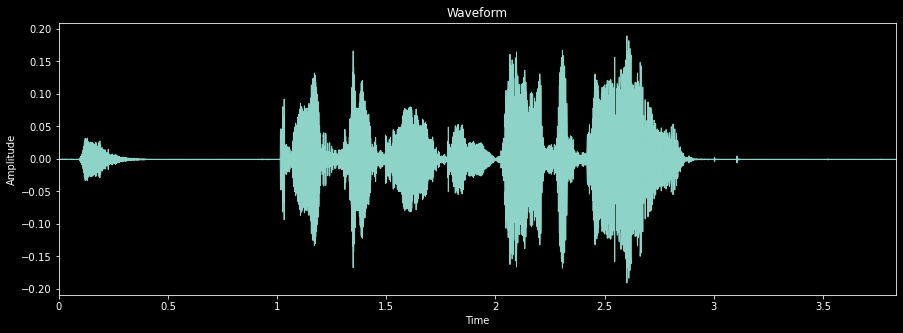

In [8]:
plt.figure(figsize=(15, 5))
plt.title('Waveform')
plt.xlabel("Time")
plt.ylabel("Amplitude")
librosa.display.waveplot(signal, sr=sr)
plt.show()

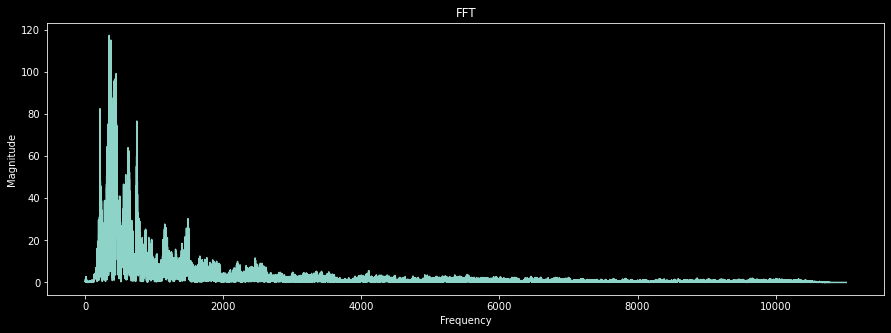

In [9]:
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

left_frequency = frequency[:int(len(frequency) / 2)]
left_magnitude = magnitude[:int(len(frequency) / 2)]

plt.figure(figsize=(15, 5))
plt.title('FFT')
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

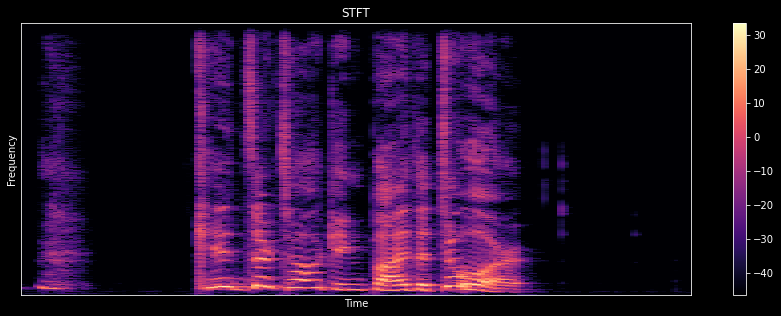

In [10]:
n_fft = 2048  # number of samples per fft
hop_length = 512  # number of samples we shift after each fft

stft = librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=(15, 5))
plt.title('STFT')
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

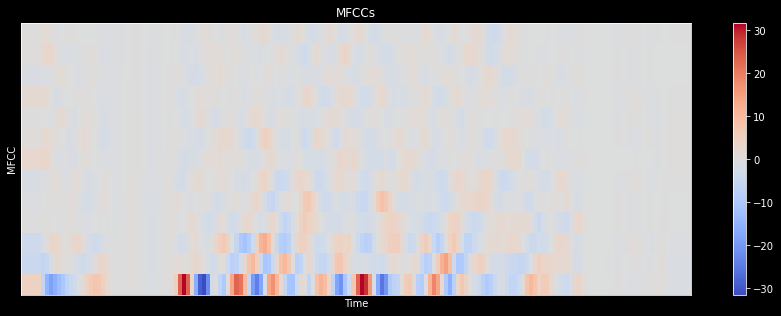

In [11]:
mfccs = librosa.feature.mfcc(signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfccs, order=2)

plt.figure(figsize=(15, 5))
plt.title('MFCCs')
librosa.display.specshow(delta2_mfcc, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

### Various plots of a random trimmed file

In [12]:
trimmed_signal, bb = librosa.effects.trim(signal, top_db=30)
print(len(signal)/SAMPLE_RATE)
print(len(trimmed_signal)/SAMPLE_RATE)
ipd.Audio(trimmed_signal, rate=sr)

3.83718820861678
2.8328344671201813


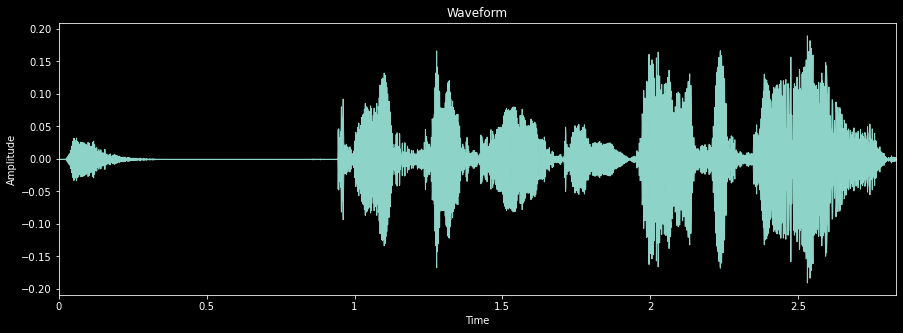

In [13]:
plt.figure(figsize=(15, 5))
plt.title('Waveform')
plt.xlabel("Time")
plt.ylabel("Amplitude")
librosa.display.waveplot(trimmed_signal, sr=sr)
plt.show()

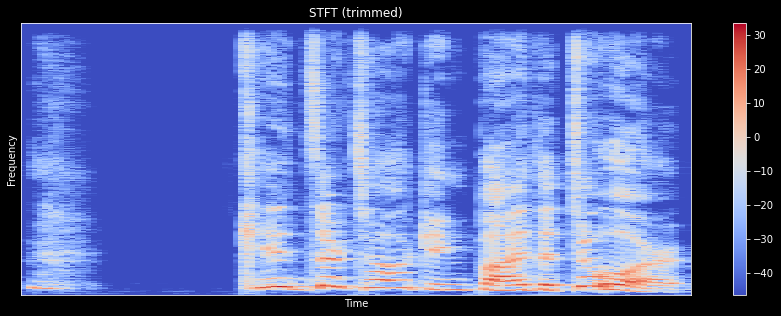

In [14]:
n_fft = 2048  # number of samples per fft
hop_length = 512  # number of samples we shift after each fft

stft = librosa.core.stft(trimmed_signal, n_fft=n_fft, hop_length=hop_length)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=(15, 5))
plt.title('STFT (trimmed)')
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

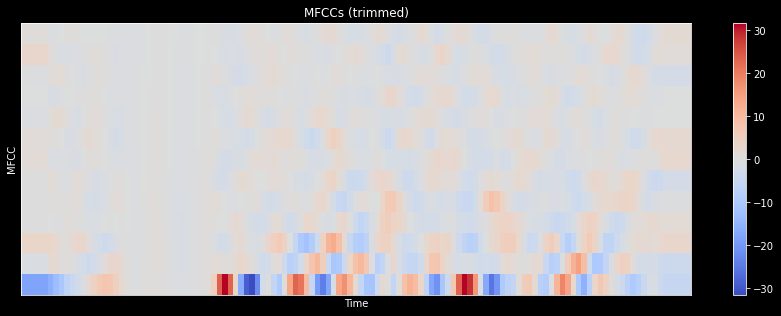

In [15]:
mfccs = librosa.feature.mfcc(trimmed_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc_trim = librosa.feature.delta(mfccs, order=2)

plt.figure(figsize=(15, 5))
plt.title('MFCCs (trimmed)')
librosa.display.specshow(delta2_mfcc_trim, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

## Defining our target labels

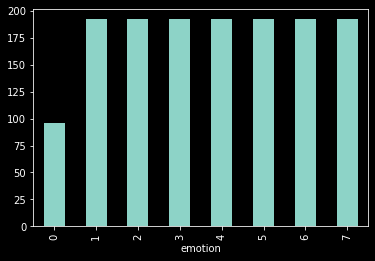

In [16]:
data_df.groupby('emotion')['path'].nunique().plot(kind='bar')

In [17]:
def extract_features(data_df):

    mfcc_list = []

    for i in tqdm(range(len(data_df))):
        signal, sr = librosa.load(data_df.path[i], sr=SAMPLE_RATE, duration=2.9)

        mfcc = librosa.feature.mfcc(signal, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
        mfcc = mfcc.T

        mfcc_list.append(mfcc.tolist())

    data_df['mfcc'] = mfcc_list
    return data_df

### Save Feature Data Files

In [18]:
pickle_file_available = os.path.isfile(PROCESSED_DATA_PICKLE_PATH)

if not pickle_file_available:
    data_df = extract_features(data_df=data_df)

In [19]:
if not pickle_file_available:
    print('\nSaving Pickle file...')
    data_df.to_pickle(PROCESSED_DATA_PICKLE_PATH)
    print("Pickle file size: {} MB".format(os.path.getsize(PROCESSED_DATA_PICKLE_PATH) / (1024 * 1024)))

In [20]:
def load_dataframe(dataset_path, use_existing_df=False, df=data_df):

    if not use_existing_df:
        df = pd.read_pickle(dataset_path)

    return df

In [21]:
data_df = load_dataframe(PROCESSED_DATA_PICKLE_PATH)
print(np.stack(data_df["mfcc"].to_numpy()))
data_df.head(3)

[[[-8.57309453e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-8.57309453e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-8.57309453e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [-8.55671364e+02  2.31375667e+00  2.30521230e+00 ...  2.04043817e+00
    1.98470885e+00  1.92455266e+00]
  [-8.56208639e+02  1.55447264e+00  1.54754295e+00 ...  1.33389912e+00
    1.28921185e+00  1.24108907e+00]
  [-8.57309453e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-8.64890286e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-8.64890286e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-8.64890286e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [-8.64890286e+02  0.0

,path,source,actor,gender,gender_label,statement,repetition,intensity,emotion,emotion_label,augmentation,mfcc
0,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,male,0,1,0,0,neutral,none,"[[-857.3094533443688, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,male,0,2,0,0,neutral,none,"[[-864.8902862773604, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,male,1,1,0,0,neutral,none,"[[-849.4454325616318, 9.397479238778757, 9.257..."


In [22]:
# identify too short mfccs
vals = []
for i, val in enumerate(data_df["mfcc"].to_numpy()):
    if len(val) < 130:
        vals.append(i)

data_df = data_df.drop(vals)
data_df = data_df.reset_index(drop=True)
inputs = np.stack(data_df["mfcc"].to_numpy())
targets = np.stack(data_df["emotion"].to_numpy())
targets2 = data_df["emotion"].to_numpy()

inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.2, random_state=42, shuffle=True)

In [23]:
# build the network architecture
regularizer = keras.regularizers.l2(0.001)
model = keras.Sequential([
    # input layer
    keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),

    # 1st hidden layer
    keras.layers.Dense(512, activation="relu"),
    # keras.layers.Dense(512, activation="relu", kernel_regularizer=regularizer),
    # keras.layers.Dropout(0.3),

    # 2nd hidden layer
    keras.layers.Dense(256, activation="relu"),
    # keras.layers.Dense(256, activation="relu", kernel_regularizer=regularizer),
    # keras.layers.Dropout(0.3),

    # 3rd hidden layer
    keras.layers.Dense(64, activation="relu"),
    # keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizer),
    # keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(8, activation="softmax")
])

# compile network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

history = model.fit(
    inputs_train,
    targets_train,
    validation_data=(inputs_test, targets_test),
    epochs=20,
    batch_size=64
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1703)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               872448    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
Total params: 1,020,744
Trainable params: 1,020,744
Non-trainable params: 0
_________________________________________________________________
Train on 1152 samples, validate on 288 samples
Epoch 1/20
1152/1152 [==============================] - 1s 1ms/sa

In [24]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

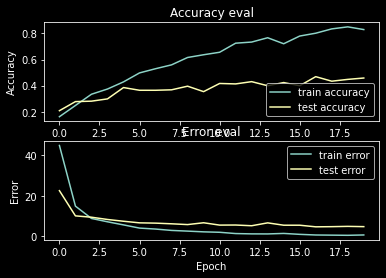

In [25]:
plot_history(history)

In [26]:
# test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
# print("Accuracy on test set is: {}".format(test_accuracy))

x = inputs_test[42:52]
emo = targets_test[42:52]

model.predict_classes(x)

array([1, 4, 7, 1, 6, 1, 4, 3, 1, 7], dtype=int64)

In [27]:
time_list = []
time_list2 = []
sample_list = []

for i in tqdm(range(len(data_df))):
    signal, sr = librosa.load(data_df.path[i], sr=SAMPLE_RATE)
    signalt, index = librosa.effects.trim(signal, top_db=30)
    x = librosa.get_duration(signal)
    y = librosa.get_duration(signalt)
    time_list.append(x)
    time_list2.append(y)
    sample_list.append(len(signal))

100%|██████████| 1440/1440 [03:16<00:00,  7.34it/s]


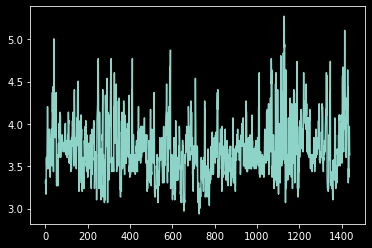

In [28]:
plt.plot(time_list)
plt.show()

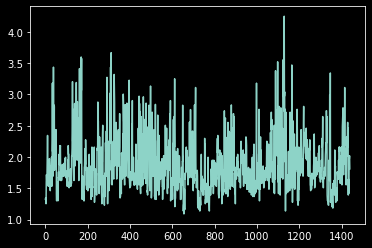

In [29]:
plt.plot(time_list2)
plt.show()

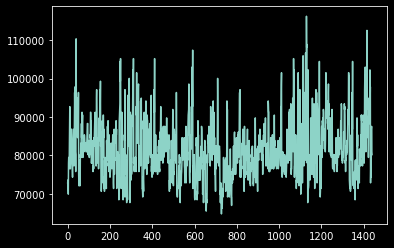

In [30]:
plt.plot(sample_list)
plt.show()

In [31]:
tl2 = np.array(time_list2)

# print(np.array(time_list).min())
print(tl2.min())
print(tl2.mean())
print(tl2.max())

# print(np.array(sample_list).min())
#
# print(np.array(sample_list).min()/SAMPLE_RATE)


1.0913378684807256
1.8739459246661627
4.250294784580499
